# NLP

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import softmax
import pandas as pd
from tqdm import tqdm
import numpy as np

/Users/martinlebras/.pyenv/versions/3.12.7/envs/ada_project_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_weighted_rating(df_predictions_batch: pd.DataFrame) -> pd.DataFrame:
    def _compute_weighted_rating(rating_weights: pd.Series):
        prediction = int(rating_weights.idxmax())

        values = [prediction]
        weights = [rating_weights.max()]

        if prediction > 1:
            values.append(prediction - 1)
            weights.append(rating_weights.loc[str(prediction - 1)])
        
        if prediction < 5:
            values.append(prediction + 1)
            weights.append(rating_weights.loc[str(prediction + 1)])
            
        return np.average(values, weights=weights)
    return df_predictions_batch.apply(_compute_weighted_rating, axis=1)

def predict_rating(reviews: pd.Series, tokenizer: AutoTokenizer, device: torch.device, model: AutoModelForSequenceClassification) -> pd.DataFrame:
    encoded_input = tokenizer(reviews.tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
    encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits, dim=1)
    return pd.DataFrame([
        *scores.cpu().numpy()
    ], columns=['1', '2', '3', '4', '5'], index=reviews.index)

def get_batch(df_ratings: pd.DataFrame, batch_id: int, batch_size: int = 50) -> pd.Series:
    df = df_ratings[df_ratings['text'].str.len() > 377]['text']
    batch = np.array_split(df.index, batch_size)[batch_id]
    return df.loc[batch]

In [3]:
df_ratings = pd.read_csv("../data/beer_advocate/ratings.csv")

HUGGING_FACE_MODEL = "nlptown/bert-base-multilingual-uncased-sentiment"
BATCH_SIZE = 50

tokenizer = AutoTokenizer.from_pretrained(HUGGING_FACE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(HUGGING_FACE_MODEL)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#device = "cpu"
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [4]:
batch_id = 12
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

100%|██████████| 408/408 [29:03<00:00,  4.27s/it]


In [5]:
batch_id = 13
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

100%|██████████| 408/408 [1:23:30<00:00, 12.28s/it]


In [6]:
batch_id = 14
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

100%|██████████| 408/408 [1:41:49<00:00, 14.98s/it]  


In [7]:
batch_id = 15
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

100%|██████████| 408/408 [1:38:46<00:00, 14.53s/it]


In [8]:
batch_id = 49
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

100%|██████████| 408/408 [2:12:00<00:00, 19.41s/it]  


In [9]:
batch_id = 48
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

 24%|██▎       | 96/408 [42:23<2:17:44, 26.49s/it]


KeyboardInterrupt: 

In [ ]:
batch_id = 47
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

In [ ]:
batch_id = 46
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

In [ ]:
batch_id = 45
batch = get_batch(df_ratings, batch_id)
sub_batch_size = 100
sub_batch_df = []

for start in tqdm(range(0, len(batch), sub_batch_size)):
    end = min(start + sub_batch_size, len(batch))
    sub_batch = batch.iloc[start:end]

    df_predictions_sub_batch = predict_rating(sub_batch, tokenizer, device, model)
    df_predictions_sub_batch['weighted_rating'] = compute_weighted_rating(df_predictions_sub_batch)
    sub_batch_df.append(df_predictions_sub_batch)

final_df = pd.concat(sub_batch_df,axis=0)
final_df.to_csv(f"prediction_batch-{batch_id}.csv",index=True)

# Beer Knowledge

\begin{equation}
K_{L,u} = \max\limits_{\mathcal{S}_i}\sqrt{\frac{|\mathcal{S}_{i,u}|}{|\mathcal{S}_i|}}
\end{equation}

\begin{equation}
K_{G,u} = \frac{|\mathcal{S}_u|}{|\mathcal{S}|} \cdot \frac{\log(1 + \overline{|\mathcal{S}_{i,u}|})}{\log(1 + \overline{|\mathcal{S}_i|})}
\end{equation}

\begin{equation}
K_u = K_{G,u} \cdot gini_u + K_{L,u} \cdot (1 - gini_u)
\end{equation}

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [56]:
df_ratings = pd.read_csv("../data/beer_advocate/ratings.csv")
df_beers = pd.read_csv("../data/beer_advocate/beers.csv")
df_users_past_beer_style = pd.read_csv("../data/beer_advocate/user_beer_style_past_ratings.csv")

In [57]:
df_ratings['date_day']  = pd.to_datetime(df_ratings['date'], unit="s").dt.round('D')
df_beer_first_app = df_ratings[["beer_id","date_day","beer_global_style"]].groupby(["beer_global_style","beer_id"]).min().reset_index()

df_new_beer_per_day = df_beer_first_app[["beer_id","date_day"]].groupby("date_day").count().reset_index().sort_values(by="date_day")

df_beer_first_app = pd.concat([df_beer_first_app,pd.get_dummies(df_beer_first_app["beer_global_style"], prefix="max").astype(int)],axis=1).drop(["beer_global_style","beer_id"],axis=1)
df_new_beer_per_day_style = df_beer_first_app.groupby("date_day").sum().sort_values(by="date_day").reset_index()

In [58]:
df_current_beer = pd.concat([df_new_beer_per_day["date_day"],df_new_beer_per_day["beer_id"].cumsum()],axis=1)
df_current_beer_per_style = pd.concat([df_new_beer_per_day_style['date_day'],df_new_beer_per_day_style.drop('date_day',axis=1).cumsum()],axis=1)

In [59]:
style_columns = [col for col in df_current_beer_per_style.columns if col != "date_day"]

df_current_beer_per_style.loc[df_current_beer_per_style["date_day"] < "2002-01-01",style_columns] = np.nan
df_current_beer_per_style_2002 = df_current_beer_per_style.bfill()

df_current_beer_per_style.loc[df_current_beer_per_style["date_day"] < "2012-01-01",style_columns] = np.nan
df_current_beer_per_style_2012 = df_current_beer_per_style.bfill()

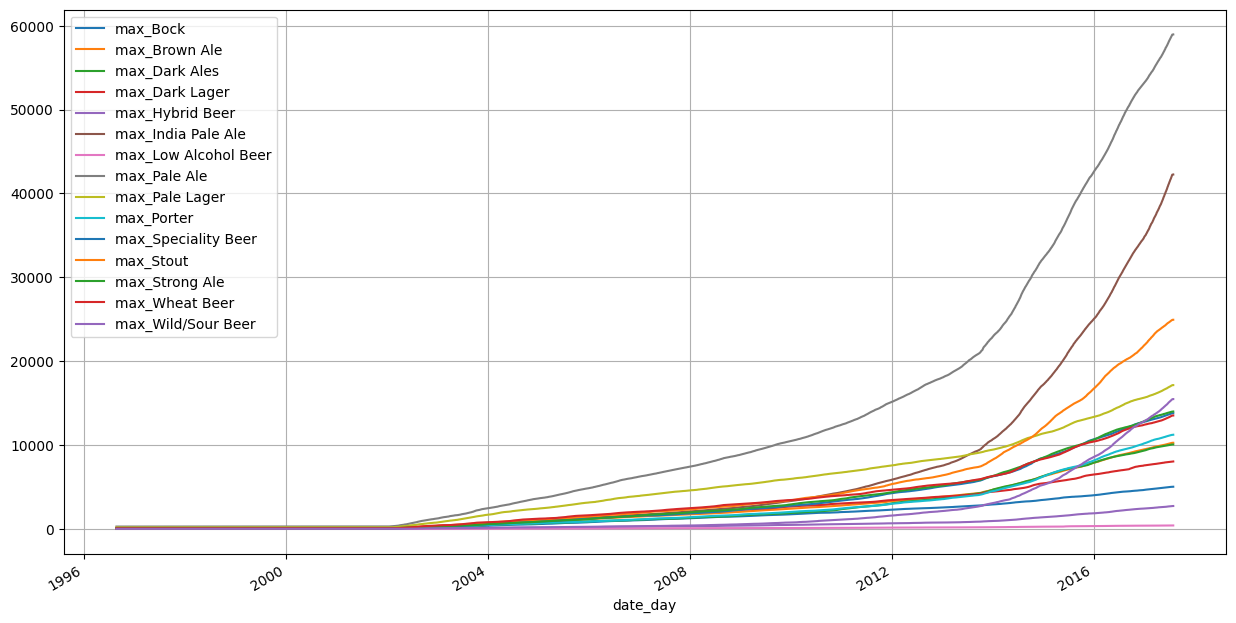

In [60]:
df_current_beer_per_style_2002.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

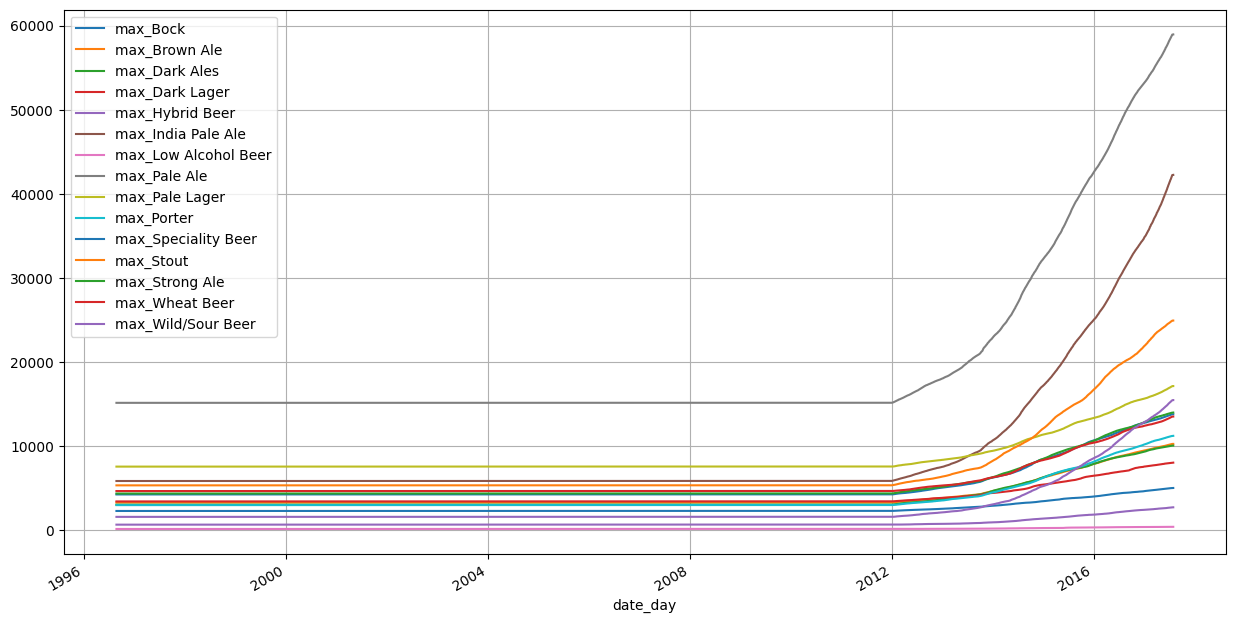

In [61]:
df_current_beer_per_style_2012.plot(x="date_day",grid=True,figsize=(15,8))
plt.show()

In [62]:
df_users_past_beer_style['date_day'] = pd.to_datetime(df_users_past_beer_style['date'], unit="s").dt.round('D')
df_users_past_beer_style = df_users_past_beer_style.merge(df_ratings[["user_id","date","beer_id","gini_impurity"]], how="left", on=["user_id","date","beer_id"])

In [63]:
useful_columns = [col for col in df_users_past_beer_style.columns if "_average" not in col]
count_columns = [col for col in df_users_past_beer_style.columns if "count" in col]
max_columns = [col for col in df_current_beer_per_style_2002.columns if "max" in col]

In [64]:
df_mean_beers = pd.concat([df_current_beer_per_style_2002["date_day"],df_current_beer_per_style_2002.iloc[:,1:].mean(axis=1)],axis=1).rename(columns={0:"mean_beers"})

df_users_past_beer_style["style_tried"] = np.sign(df_users_past_beer_style[count_columns]).sum(axis=1)
df_users_past_beer_style["style_tried_share"] = df_users_past_beer_style["style_tried"] / 15
df_users_past_beer_style["mean_beer_tried"] = df_users_past_beer_style[count_columns].sum(axis=1) / df_users_past_beer_style["style_tried"]
df_users_past_beer_style = df_users_past_beer_style.merge(df_mean_beers, how="left", on="date_day")

df_users_past_beer_style.sort_values(by="date_day",inplace=True)
df_users_past_beer_style["mean_beers"] = df_users_past_beer_style["mean_beers"].ffill()

df_users_past_beer_style.loc[df_users_past_beer_style["style_tried"] == 0,"mean_beer_tried"] = 0

In [65]:
df_users_past_beer_style["global_knowledge"] = df_users_past_beer_style["style_tried_share"] * np.log(1 + df_users_past_beer_style["mean_beer_tried"]) / np.log(1 + df_users_past_beer_style["mean_beers"])

In [ ]:
df_users_past_beer_style = df_users_past_beer_style.merge(df_current_beer_per_style_2002, how="left", on="date_day")
df_users_past_beer_style.sort_values(by="date_day",inplace=True)
df_users_past_beer_style[max_columns] = df_users_past_beer_style[max_columns].ffill()

df_shares_by_style = pd.DataFrame(df_users_past_beer_style[count_columns].values / df_users_past_beer_style[max_columns].values)
df_knowledge = pd.concat([df_users_past_beer_style,np.sqrt(df_shares_by_style.max(axis=1))],axis=1).rename({0:"local_knowledge"},axis=1)

In [ ]:
df_knowledge = df_knowledge[["user_id","date_day","beer_id","gini_impurity","global_knowledge","local_knowledge"]]
df_knowledge["knowledge"] = df_knowledge["gini_impurity"] * df_knowledge["global_knowledge"] + (1 - df_knowledge["gini_impurity"]) * df_knowledge["local_knowledge"]
df_knowledge.loc[df_users_past_beer_style["style_tried"] == 0, "knowledge"] = 0

In [125]:
df_knowledge.drop(["local_knowledge","knowledge"],axis=1,inplace=True)

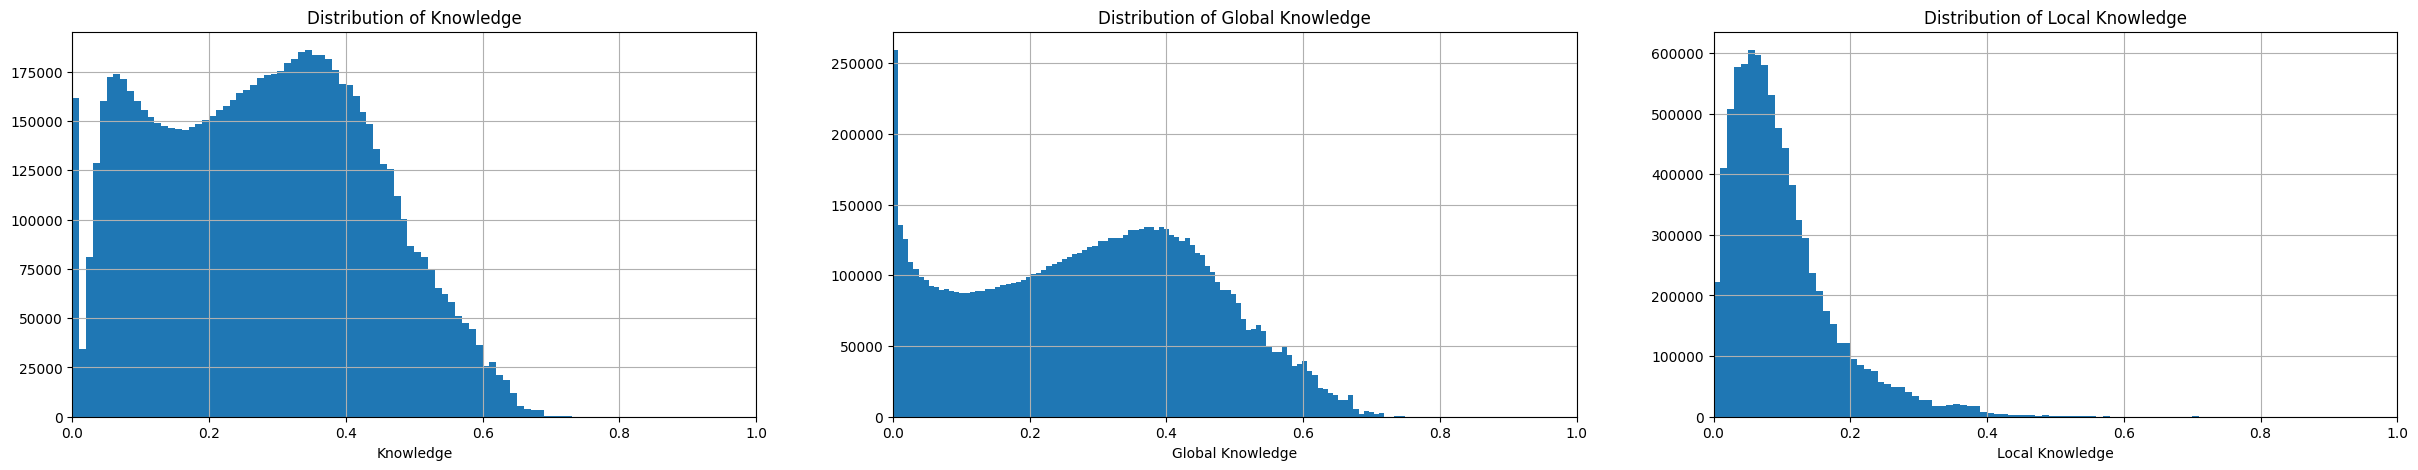

In [130]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_knowledge["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_knowledge["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_knowledge["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

In [131]:
df_max_knowledge_per_user = df_knowledge.groupby("user_id").max().reset_index()
df_max_knowledge_per_user.drop(df_max_knowledge_per_user[df_max_knowledge_per_user["knowledge"] == 0].index, axis=0, inplace=True)

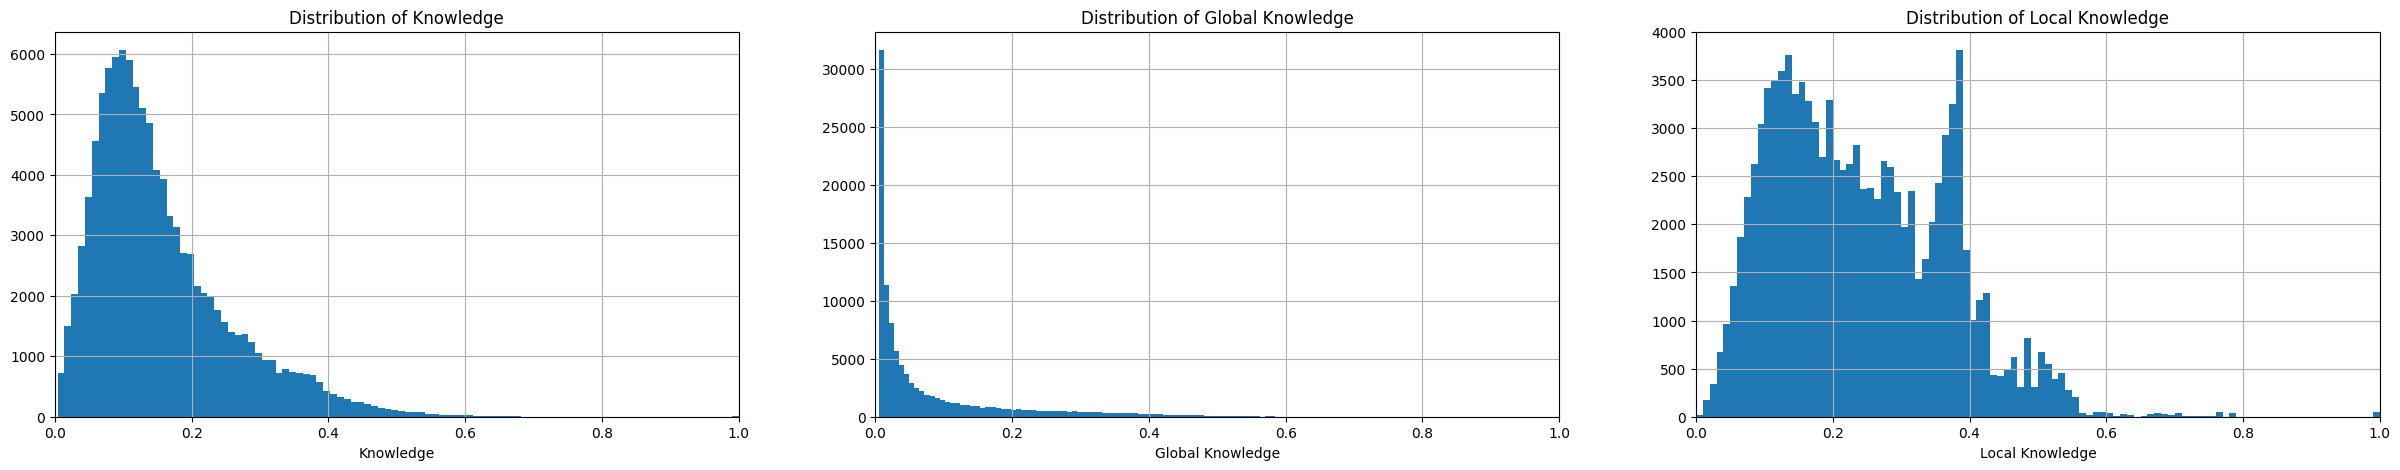

In [133]:
plt.figure(figsize=(30,5))

plt.subplot(1,3,1)
df_max_knowledge_per_user["knowledge"].hist(bins=100)
plt.title("Distribution of Knowledge")
plt.xlabel("Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,2)
df_max_knowledge_per_user["global_knowledge"].hist(bins=100)
plt.title("Distribution of Global Knowledge")
plt.xlabel("Global Knowledge")
plt.xlim([0,1])

plt.subplot(1,3,3)
df_max_knowledge_per_user["local_knowledge"].hist(bins=100)
plt.title("Distribution of Local Knowledge")
plt.xlabel("Local Knowledge")
plt.xlim([0,1])

plt.show()

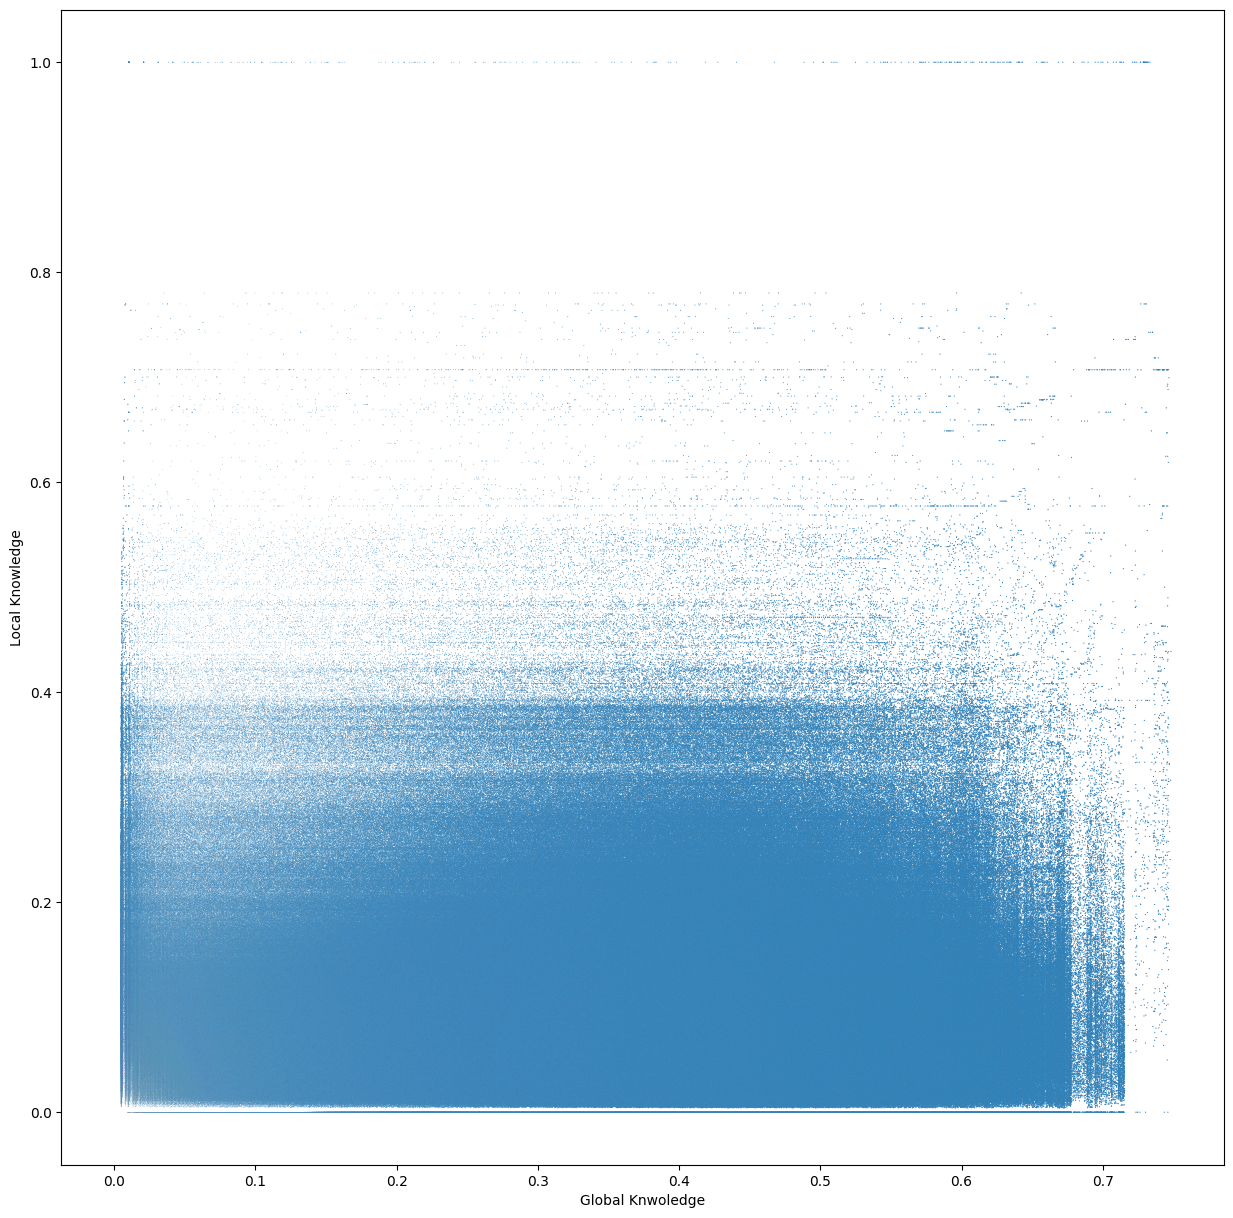

In [140]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=df_knowledge["global_knowledge"], y=df_knowledge["local_knowledge"],s=df_knowledge["knowledge"])
plt.xlabel("Global Knwoledge")
plt.ylabel("Local Knowledge")
plt.show()

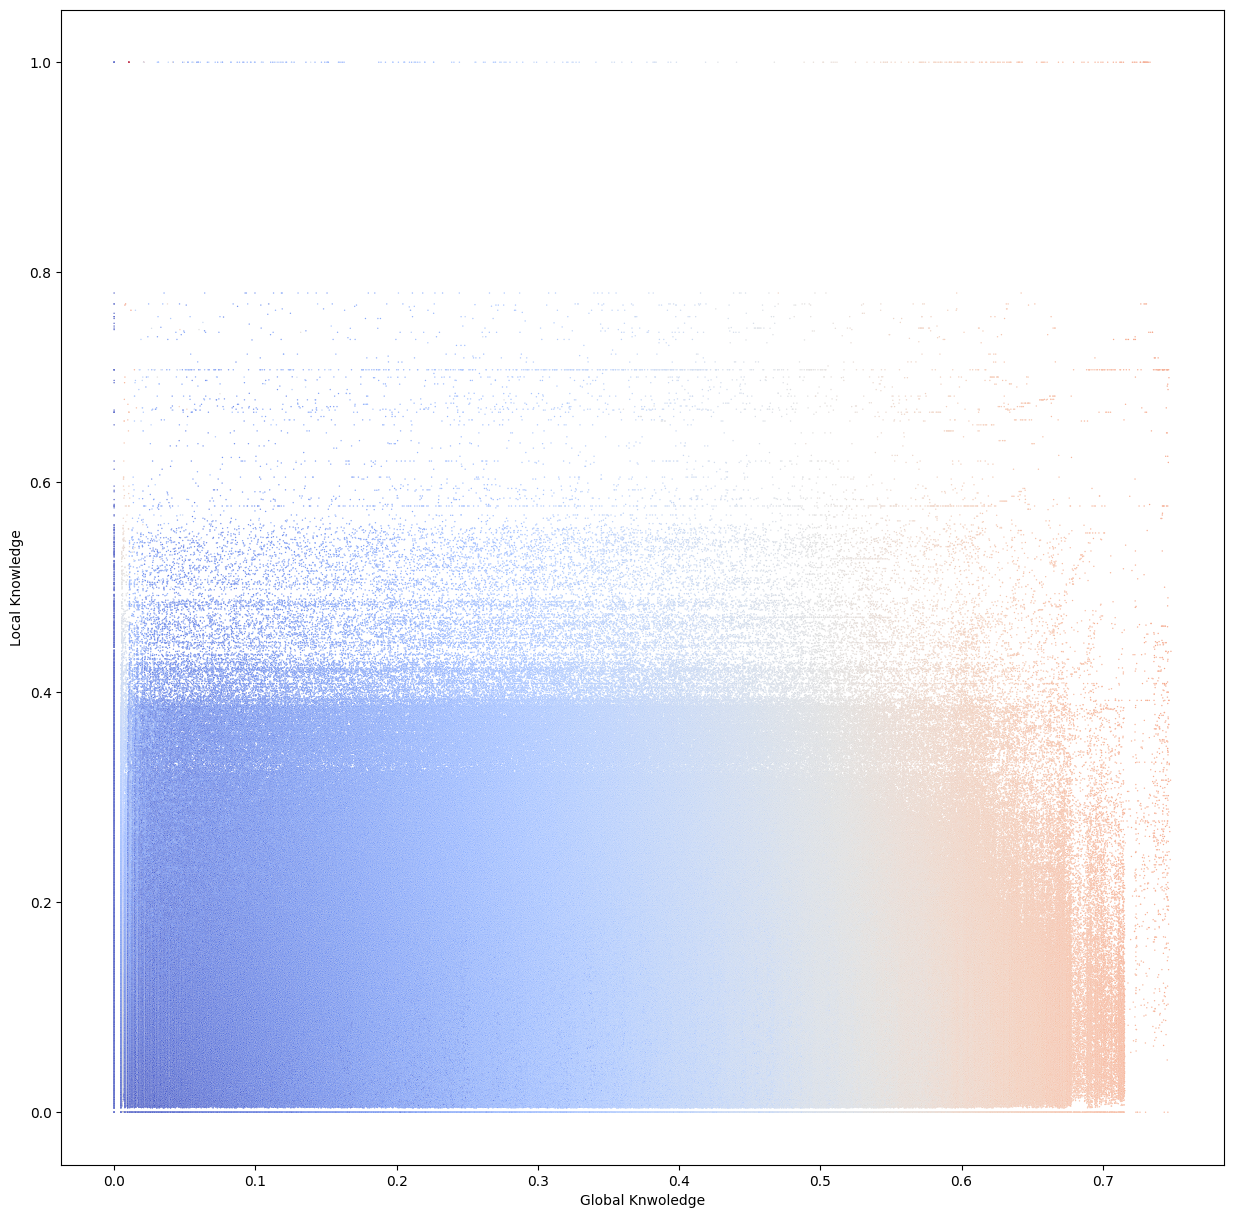

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=df_knowledge["global_knowledge"], y=df_knowledge["local_knowledge"],hue=df_knowledge["knowledge"], palette="coolwarm", s=1, legend=False)
plt.xlabel("Global Knowledge")
plt.ylabel("Local Knowledge")
plt.show()